# Estimate the liquidity factor from T-bill yields

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Estimate liquidity factor using the Svensson curve

Load the Svensson curve coefficients

In [2]:
df = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Gurkaynak, Sack, Wright. 2006. The U.S. Treasury Yield Curve 1961 to the Present/svensson_coefs.dta')

df.index = pd.PeriodIndex(df['date'], freq='D')

del df['date']

df = df.resample('M').last()
df.head()

,beta0,beta1,beta2,beta3,tau1,tau2
date,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999


Compute zero-coupon yield curve for 3-month maturity

In [3]:
n = 3/12

df['term1'] = (1 - np.exp(-n/df['tau1'])) / (n/df['tau1'])
df['term2'] = df['term1'] - np.exp(-n/df['tau1'])
df['term3'] = (1 - np.exp(-n/df['tau2'])) / (n/df['tau2']) - np.exp(-n/df['tau2'])

df['sven_m3'] = df['beta0'] + df['beta1'] * df['term1'] + df['beta2'] * df['term2'] + df['beta3'] * df['term3']

del df['term1']
del df['term2']
del df['term3']
            
df.head()

,beta0,beta1,beta2,beta3,tau1,tau2,sven_m3
date,,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999,2.666255
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999,2.279885
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999,2.734870
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999,2.492253
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999,2.503662


Compare to the zero-coupon yield datafile to confirm that the formula is right

In [4]:
# df_compare = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Gurkaynak, Sack, Wright. 2006. The U.S. Treasury Yield Curve 1961 to the Present/zero_coupon_yields_monthly_end.dta')

# df_compare.index = pd.PeriodIndex(df_compare['date'], freq='M')

# combined = pd.concat([df, df_compare], axis=1)

# combined[['yield1', 'sveny01']].corr()

1. Combine with 3-month yields from FRED
2. Create the liquidity factor as the deviation of 3m T-bill yields from the Svensson curve

In [5]:
df_m3 = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Treasury Bills/yield_tbills_monthly_end.dta')

df_m3.index = pd.PeriodIndex(df_m3['date'], freq='M')

del df_m3['date']

In [6]:
df = df.join(df_m3['m3'])

df['liq_sven'] = df['m3'] - df['sven_m3']

df.head()

,beta0,beta1,beta2,beta3,tau1,tau2,sven_m3,m3,liq_sven
date,,,,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999,2.666255,2.27,-0.396255
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999,2.279885,2.26,-0.019885
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999,2.734870,2.35,-0.384870
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999,2.492253,2.23,-0.262253
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999,2.503662,2.28,-0.223662


Create a new DataFrame to store the liquidity factor

In [7]:
df_liq_factors = pd.DataFrame(df['liq_sven'])

## Create liquidity factor as the regression residuals

In [8]:
df_FamaBliss = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from CRSP/Fama-Bliss Discount Bond Yields.dta')
df_pers_infl = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from CRSP/risk_premium_factors.dta')

df_combined = df_FamaBliss.merge(df_pers_infl, on='date', how='outer')

df_combined.index = pd.PeriodIndex(df_FamaBliss['date'], freq='M')

del df_combined['date']

df_combined = df_combined.join(df_m3['m3'])
df_combined = df_combined.loc[df_combined['m3'].notnull()]
# df_combined = df_combined.loc[df_combined['pers_infl'].notnull()]

df_combined.head()

,yield1,yield2,yield3,yield4,yield5,pers_infl,c1,cycle,tent,m3
date,,,,,,,,,,
1954-01,1.154014,1.440317,1.670869,1.693738,2.123211,NaN,NaN,NaN,-0.010838,1.02
1954-02,1.100329,1.293659,1.496239,1.628125,1.879197,NaN,NaN,NaN,-0.003785,1.00
1954-03,1.058494,1.211848,1.425534,1.596892,1.817478,NaN,NaN,NaN,-0.001570,1.03
1954-04,0.837529,1.136069,1.382004,1.544456,1.579254,NaN,NaN,NaN,0.005814,0.81
1954-05,0.847967,1.097936,1.429154,1.825164,1.773992,NaN,NaN,NaN,0.019891,0.72


In [9]:
df_combined.tail()

,yield1,yield2,yield3,yield4,yield5,pers_infl,c1,cycle,tent,m3
date,,,,,,,,,,
2016-08,0.676320,0.819596,0.939961,1.128652,1.221504,0.018654,-0.014159,-0.005345,-0.001519,0.33
2016-09,0.663800,0.782954,0.896652,1.068444,1.175224,0.018680,-0.014321,-0.005726,-0.003147,0.28
2016-10,0.697406,0.859965,1.000571,1.205819,1.335289,0.018695,-0.014007,-0.004787,-0.000890,0.34
2016-11,0.889716,1.115353,1.401609,1.721781,1.879066,0.018711,-0.012106,-0.001943,0.009221,0.48
2016-12,0.858817,1.195558,1.451491,1.759157,1.948628,0.018744,-0.012462,-0.001131,0.008096,0.50


### Estimate liquidity factor as the residuals from the regression on Fama-MacBeth bond yields

In [10]:
exog = sm.add_constant(df_combined.loc[:, 'yield1':'yield5'])

ols = sm.OLS(df_combined['m3'], exog, missing='drop')

results = ols.fit()

print(results.summary())

df_combined['liq_resid1'] = results.resid

                            OLS Regression Results                            
Dep. Variable:                     m3   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.370e+04
Date:                Fri, 03 Nov 2017   Prob (F-statistic):               0.00
Time:                        11:32:09   Log-Likelihood:                -213.01
No. Observations:                 756   AIC:                             438.0
Df Residuals:                     750   BIC:                             465.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0980      0.035     -2.815      0.0

### Estimate liquidity factor as the residuals from the regression on Fama-MacBeth bond yields and inflation

In [11]:
exog['pers_infl'] = df_combined['pers_infl']

ols = sm.OLS(df_combined['m3'], exog, missing='drop')

results = ols.fit()

print(results.summary())

df_combined['liq_resid2'] = results.resid

                            OLS Regression Results                            
Dep. Variable:                     m3   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9975.
Date:                Fri, 03 Nov 2017   Prob (F-statistic):               0.00
Time:                        11:32:09   Log-Likelihood:                -175.31
No. Observations:                 588   AIC:                             364.6
Df Residuals:                     581   BIC:                             395.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1098      0.047     -2.348      0.0

In [12]:
df_liq_factors = df_liq_factors.join(df_combined[['liq_resid1', 'liq_resid2']], how='outer')
df_liq_factors.to_csv('liquidity_factor.csv')

In [13]:
df_liq_factors.head()

,liq_sven,liq_resid1,liq_resid2
date,,,
1954-01,NaN,0.196302,NaN
1954-02,NaN,0.142356,NaN
1954-03,NaN,0.180422,NaN
1954-04,NaN,0.303716,NaN
1954-05,NaN,0.117173,NaN


In [14]:
df_liq_factors.tail(20)

,liq_sven,liq_resid1,liq_resid2
date,,,
2016-03,-0.334085,-0.228099,-0.241328
2016-04,-0.265654,-0.142620,-0.147100
2016-05,-0.299722,-0.177815,-0.192062
2016-06,-0.231278,-0.146253,-0.172317
2016-07,-0.278383,-0.225805,-0.254438
2016-08,-0.246704,-0.185876,-0.204017
2016-09,-0.319536,-0.235286,-0.252461
2016-10,-0.269915,-0.190433,-0.204596
2016-11,-0.221126,-0.195512,-0.225079


In [23]:
df_liq_factors.describe()

,liq_sven,liq_resid1,liq_resid2
count,677.000000,7.560000e+02,5.880000e+02
mean,-0.269335,1.863045e-14,-2.808940e-14
std,0.363215,3.209342e-01,3.262973e-01
min,-2.284201,-1.852073e+00,-1.950204e+00
25%,-0.356117,-1.459302e-01,-1.527349e-01
50%,-0.215203,8.977916e-03,2.371918e-03
75%,-0.122808,1.838156e-01,1.802825e-01
max,2.669075,1.822234e+00,1.721922e+00


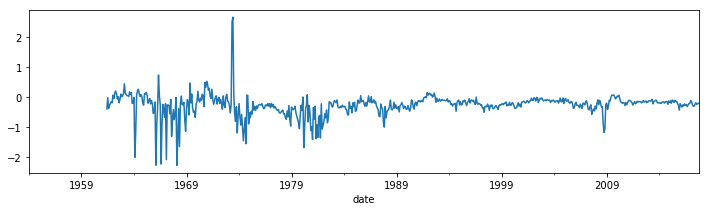

In [20]:
df_liq_factors['liq_sven'].plot(figsize=(12,3))

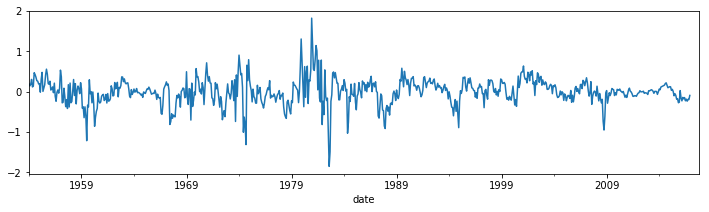

In [21]:
df_liq_factors['liq_resid1'].plot(figsize=(12,3))

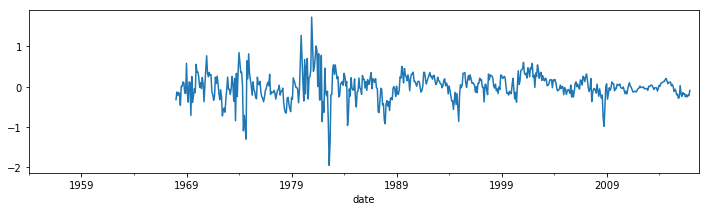

In [22]:
df_liq_factors['liq_resid2'].plot(figsize=(12,3))

In [19]:
df_liq_factors.corr()

,liq_sven,liq_resid1,liq_resid2
liq_sven,1.000000,0.211971,0.231738
liq_resid1,0.211971,1.000000,0.992171
liq_resid2,0.231738,0.992171,1.000000
